<a href="https://colab.research.google.com/github/Avinashreddy-07/Homework-4_NLP/blob/main/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10 — train_loss: 0.4592  val_loss: 0.0396
Epoch 2/10 — train_loss: 0.0328  val_loss: 0.0282
Epoch 3/10 — train_loss: 0.0276  val_loss: 0.0239
Epoch 4/10 — train_loss: 0.0259  val_loss: 0.0287
Epoch 5/10 — train_loss: 0.0252  val_loss: 0.0276
Epoch 6/10 — train_loss: 0.0250  val_loss: 0.0246
Epoch 7/10 — train_loss: 0.0246  val_loss: 0.0253
Epoch 8/10 — train_loss: 0.0246  val_loss: 0.0234
Epoch 9/10 — train_loss: 0.0245  val_loss: 0.0241
Epoch 10/10 — train_loss: 0.0243  val_loss: 0.0225


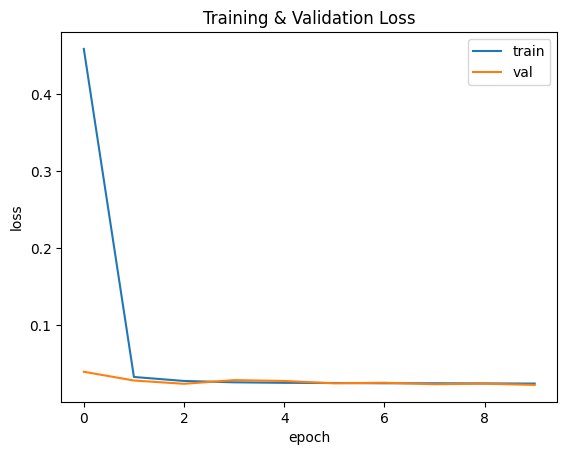


--- Samples ---

Temperature 0.7:

hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet h

------------------------------------------------------------

Temperature 1.0:

helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help 

------------------------------------------------------------

Temperature 1.2:

helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello

In [1]:
# char_rnn.py
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------------------------
# 1) Data (toy + easy swap)
# ---------------------------
toy = "hello help helmet hello hell helpful help hello world " * 200  # ~ small corpus
text = toy.lower()

# If you want to use a file instead, uncomment and set filename:
# with open("my_text.txt", "r", encoding="utf-8") as f:
#     text = f.read().lower()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s): return [stoi[c] for c in s]
def decode(ids): return ''.join(itos[i] for i in ids)

data = torch.tensor(encode(text), dtype=torch.long)

# Train / val split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# ---------------------------
# 2) Model
# ---------------------------
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, h=None):
        # x: (batch, seq)
        emb = self.embed(x)  # (batch, seq, embed)
        out, h = self.rnn(emb, h)  # out: (batch, seq, hidden)
        logits = self.fc(out)  # (batch, seq, vocab)
        return logits, h

# ---------------------------
# 3) Training helpers
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharRNN(vocab_size, embed_size=64, hidden_size=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

seq_len = 80
batch_size = 64
epochs = 10
steps_per_epoch = 200  # adjust smaller if dataset tiny

def get_batch(split='train'):
    d = train_data if split == 'train' else val_data
    max_start = len(d) - seq_len - 1
    if max_start <= 0:
        raise ValueError("Dataset too small for the sequence length. Reduce seq_len.")
    starts = torch.randint(0, max_start, (batch_size,))
    x = torch.stack([d[s:s+seq_len] for s in starts])
    y = torch.stack([d[s+1:s+seq_len+1] for s in starts])
    return x.to(device), y.to(device)

# ---------------------------
# 4) Train loop
# ---------------------------
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    for step in range(steps_per_epoch):
        xb, yb = get_batch('train')
        optimizer.zero_grad()
        logits, _ = model(xb)  # (batch, seq, vocab)
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        epoch_loss += loss.item()
    train_loss = epoch_loss / steps_per_epoch

    # validation
    model.eval()
    with torch.no_grad():
        xb, yb = get_batch('val')
        logits, _ = model(xb)
        val_loss = criterion(logits.view(-1, vocab_size), yb.view(-1)).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{epochs} — train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}")

# ---------------------------
# 5) Plot losses
# ---------------------------
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# ---------------------------
# 6) Sampling (temperature)
# ---------------------------
def sample(model, start_char='h', length=300, temperature=1.0):
    model.eval()
    with torch.no_grad():
        idx = torch.tensor([[stoi[start_char]]], dtype=torch.long).to(device)  # (1,1)
        hidden = None
        out = start_char
        for _ in range(length):
            logits, hidden = model(idx, hidden)  # logits: (1,1,vocab)
            logits = logits[0, -1] / max(1e-8, temperature)
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).item()
            out += itos[next_id]
            idx = torch.tensor([[next_id]], dtype=torch.long).to(device)
        return out

print("\n--- Samples ---")
for t in [0.7, 1.0, 1.2]:
    print(f"\nTemperature {t}:\n")
    print(sample(model, start_char='h', length=300, temperature=t))
    print("\n" + "-"*60)

# ---------------------------
# 7) Short reflection (printed)
# ---------------------------
print("\nReflection:")
print("- Increasing sequence length helps capture longer dependencies but raises memory and compute.")
print("- Increasing hidden size typically improves capacity/fluency but risks overfitting on small data.")
print("- Temperature <1 makes output more deterministic; >1 makes it more diverse but error-prone.")


Input tokens (first sentence): ['i', 'love', 'deep', 'learning']
Contextual embeddings shape: torch.Size([10, 5, 64])
Attention weights shape: torch.Size([10, 4, 5, 5])


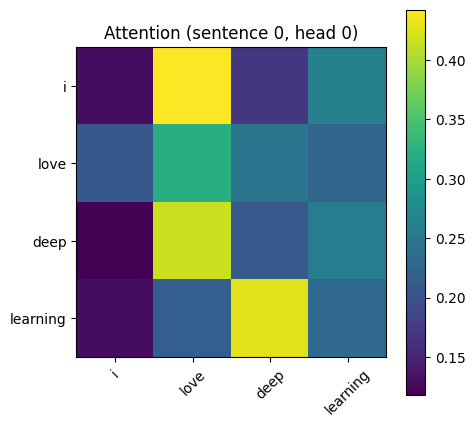


Contextual embedding (first token of first sentence):
tensor([-2.0329, -0.0276, -0.1472,  0.6125,  0.3589,  0.5645,  1.4584,  0.8844],
       grad_fn=<SliceBackward0>)


In [2]:
# mini_transformer.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------------------------
# 1) Small dataset
# ---------------------------
sentences = [
    "i love deep learning",
    "transformers are powerful",
    "attention is all you need",
    "nlp is fun",
    "pytorch makes it easy",
    "the model learns patterns",
    "language models are cool",
    "machine learning is amazing",
    "rnn and lstm remember context",
    "we build a mini transformer"
]

# tokenize by whitespace, build vocab
tokens = [s.split() for s in sentences]
vocab = sorted(set(word for sent in tokens for word in sent))
tok2id = {w: i+1 for i, w in enumerate(vocab)}  # reserve 0 for pad
tok2id['<pad>'] = 0
id2tok = {i: w for w, i in tok2id.items()}

max_len = max(len(t) for t in tokens)
inputs = torch.tensor([[tok2id[w] for w in sent] + [0]*(max_len-len(sent)) for sent in tokens])  # (batch, seq)
batch_size, seq_len = inputs.shape
vocab_size = len(tok2id)

# ---------------------------
# 2) Positional encoding
# ---------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):
        # x shape: (batch, seq, d_model)
        return x + self.pe[:, :x.size(1), :]

# ---------------------------
# 3) Mini encoder layer (using nn.MultiheadAttention)
# ---------------------------
class MiniEncoderLayer(nn.Module):
    def __init__(self, d_model=64, n_heads=4, dim_ff=128):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, src_key_padding_mask=None):
        # x: (batch, seq, d_model)
        attn_out, attn_weights = self.self_attn(x, x, x, need_weights=True, average_attn_weights=False,
                                                key_padding_mask=src_key_padding_mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        # attn_weights shape when average_attn_weights=False -> (batch, num_heads, seq, seq)
        return x, attn_weights

# ---------------------------
# 4) Build model and forward
# ---------------------------
d_model = 64
embed = nn.Embedding(vocab_size, d_model, padding_idx=0)
pos_enc = PositionalEncoding(d_model, max_len=max_len)
encoder_layer = MiniEncoderLayer(d_model=d_model, n_heads=4, dim_ff=128)

# prepare input
x = embed(inputs)  # (batch, seq, d_model)
x = pos_enc(x)

# compute padding mask (True where pad)
pad_mask = (inputs == 0)  # (batch, seq)

contextual, attn_weights = encoder_layer(x, src_key_padding_mask=pad_mask)

print("Input tokens (first sentence):", tokens[0])
print("Contextual embeddings shape:", contextual.shape)  # (batch, seq, d_model)
print("Attention weights shape:", attn_weights.shape)    # (batch, heads, seq, seq)

# ---------------------------
# 5) Visualize attention for one sentence and one head
# ---------------------------
def plot_attention(sentence_idx=0, head_idx=0):
    attn = attn_weights[sentence_idx, head_idx].detach().cpu().numpy()
    token_list = tokens[sentence_idx]
    L = len(token_list)
    plt.figure(figsize=(5,5))
    plt.imshow(attn[:L, :L], origin='upper', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(L), token_list, rotation=45)
    plt.yticks(range(L), token_list)
    plt.title(f"Attention (sentence {sentence_idx}, head {head_idx})")
    plt.show()

plot_attention(sentence_idx=0, head_idx=0)

# Print a small snippet of contextual embedding values
print("\nContextual embedding (first token of first sentence):")
print(contextual[0, 0, :8])  # print first 8 dims


In [3]:
# attention_test.py
import torch
import torch.nn.functional as F
import math

def scaled_dot_product_attention(Q, K, V, eps=1e-9):
    """
    Q: (batch, seq_q, d_k)
    K: (batch, seq_k, d_k)
    V: (batch, seq_k, d_v)  typically d_v == d_k or different
    returns: (output, attn_weights)
    attn_weights: (batch, seq_q, seq_k)
    """
    d_k = Q.size(-1)
    # compute raw scores
    scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch, seq_q, seq_k)
    # scale
    scaled = scores / math.sqrt(d_k)
    # softmax
    attn_weights = F.softmax(scaled, dim=-1)
    # attention output
    output = torch.matmul(attn_weights, V)  # (batch, seq_q, d_v)
    return output, attn_weights, scores, scaled

# ---------------------------
# Test with random tensors
# ---------------------------
batch = 2
seq_q = 3
seq_k = 4
d_k = 8
d_v = 6

torch.manual_seed(0)
Q = torch.randn(batch, seq_q, d_k) * 5.0  # larger values highlight stability issues
K = torch.randn(batch, seq_k, d_k) * 5.0
V = torch.randn(batch, seq_k, d_v)

out, attn, raw_scores, scaled_scores = scaled_dot_product_attention(Q, K, V)

print("Raw scores (first batch):")
print(raw_scores[0])          # before scaling

print("\nScaled scores (first batch):")
print(scaled_scores[0])       # after dividing by sqrt(d_k)

print("\nAttention weights (first batch):")
print(attn[0])                # softmax after scaling

print("\nOutput vectors (first batch):")
print(out[0])                 # (seq_q, d_v)

# ---------------------------
# Softmax stability check (compare softmax on raw_scores vs scaled)
# ---------------------------
def stable_softmax(x, dim=-1):
    # numerically stable softmax
    x_max = x.max(dim=dim, keepdim=True).values
    e_x = torch.exp(x - x_max)
    return e_x / (e_x.sum(dim=dim, keepdim=True) + 1e-12)

print("\nSoftmax on raw scores (first batch, first query):")
print(stable_softmax(raw_scores[0, 0]))

print("\nSoftmax on scaled scores (first batch, first query):")
print(stable_softmax(scaled_scores[0, 0]))

print("\nObservation: The scaled softmax is much less peaky for large d_k and avoids extremely small/large exponents.")


Raw scores (first batch):
tensor([[ -9.8017, -94.4474, -32.3874,  25.2750],
        [-17.5862,  23.9282,  45.7350,  18.5804],
        [ -6.9268,  56.7248, -80.7860,  40.9035]])

Scaled scores (first batch):
tensor([[ -3.4654, -33.3922, -11.4507,   8.9361],
        [ -6.2177,   8.4599,  16.1698,   6.5692],
        [ -2.4490,  20.0552, -28.5622,  14.4616]])

Attention weights (first batch):
tensor([[4.1125e-06, 4.1406e-19, 1.4001e-09, 1.0000e+00],
        [1.8925e-10, 4.4815e-04, 9.9948e-01, 6.7654e-05],
        [1.6785e-10, 9.9629e-01, 7.6580e-22, 3.7076e-03]])

Output vectors (first batch):
tensor([[-0.8048,  0.5656,  0.6104,  0.4669,  1.9507, -1.0631],
        [ 0.1234,  1.1642,  0.9227,  1.3864, -0.8819, -0.4189],
        [-0.9210, -0.0539, -0.6181, -0.4603,  1.9219, -0.4050]])

Softmax on raw scores (first batch, first query):
tensor([5.8399e-16, 0.0000e+00, 9.0685e-26, 1.0000e+00])

Softmax on scaled scores (first batch, first query):
tensor([4.1125e-06, 4.1406e-19, 1.4001e-09, 1.0